<a href="https://colab.research.google.com/github/asifsundrani/Assignment_3/blob/master/W3_sundrani_qq301451(v6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Your name:
 Asif Sundrani
Collaborators:
 NA

# Classification - Assignment Details

Q1. Build a classification model for the default of credit card clients dataset. More info here: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Explore the data
Make sure you build a full data pipeline
Do you require any data pre-processing? Are all the features useful? (Use only raw features)
set the random seed to 123 (For splitting or any other random algorithm)
Split data into training (80%) and testing (20%)
Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember apendix B
Study the ROC Curve, decide threshold

Use 2 classifiers.
Random Forest
tune only: n_estimators: {3, 4, 6, 7, 10, 20, 50, 100}

KNN Classfier
tune only: n_neighbors: {3, 4, 5, 7, 10, 20, 50}

Which one performs better in the cross validation?

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Cross-validation with 4-folds.
Other paramenters -> Use default

Notes:
Make your code modular, the second part of the assignmet you will have to repeat.
Include documentation for your code
Cross-validation with 5-folds

# Python Import Details

In [0]:

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import precision_score, recall_score,f1_score,roc_curve,roc_auc_score,confusion_matrix,precision_recall_curve

import seaborn as sns
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [0]:
import urllib.request
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls'
urllib.request.urlretrieve(url, '/Users/asif/Downloads/cat.xls')

In [0]:
import requests
import urllib
outfilename = "test.xls"
url_of_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/default of credit card clients.xls'
urllib.request.urlretrieve(url_of_file, outfilename) 

In [0]:
import pandas as pd
df=pd.read_excel(r'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls',sheet_name=0,skiprows=1,header=0)    



In [0]:
!wget https://archive.ics.uci.edu/ml/datasets/default of credit card clients.xls\n


# Data Extraction

In [5]:
# Import data set file from the website (this command is not working)
#link='https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls'
#df=pd.read_excel(link,sheet_name=0,skiprows=1,header=0)

#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt

#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls/  

  #!wget https://archive.ics.uci.edu/ml/datasets/default of credit card clients.xls

df=pd.read_excel('default of credit card clients.xls',sheet_name=0,skiprows=1,header=0)    

df_original=df
df_original.shape

(30000, 25)

# Data Review

In [0]:
df.head()

In [0]:
df.info()

There are 30K recrods and 25 features. There is no data missing in the file and all of them are int64

In [0]:
df.describe()

In [6]:
default_ratio=(np.sum(df['default payment next month'])/len(df['default payment next month'])*100)
print('Default Ratio: {}'.format(default_ratio))


Default Ratio: 22.12


**Limit Balance:** standard deviation is very high which mean the data is not normally distributed. 75% of the clients credit limit is below $250K

**Education:** Max level is 6, however, in the dataset it was defined upto 4 so need to merge other 2 into 4(others) category.

Marital Status: There are 56 records with '0' status which needs to be merged with status others marked as 3

**Age: **75% of the data age limit is 41 or lower.Worth to check default ratio among retire assuming 65 years

**Payment status: **There is a negative payment status defined in the data set, looks like client credit card balance is negative to represent this. So need to uniform these anamolies as we need to distinguish between default vs non default. Put negative category to zero.
**Statement Balance:** 75% of the customers average statement balance is between $49K to $67K. However there are certain accounts have negative balance which is needs to be investigated.

**Payments:** 75% of clients paid ~$5K which is far different than average statement balance of $67K. Clients majority of the clients paid minimum balance to avoid default

**Default Ratio: **Overall default ratio is 22.12% over this dataset.



# Data Clean up


1.   **Merge undefined Education 5&6 classification into 4**




In [7]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [8]:
Edu_data=(df.EDUCATION==5)|(df.EDUCATION==6)|(df.EDUCATION==0)
df.loc[Edu_data,'EDUCATION']=4
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64


2.   **Merge undefined marriage classification of '0' into classification 3**



In [9]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [10]:
Mar_data=(df.MARRIAGE==0)
df.loc[Mar_data,'MARRIAGE']=3
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64


3.   **Create a group of Ages to evaluate results** 




In [0]:
 df.AGE.value_counts()



4.   **Merge '-1&-2' payment period category into '0' classification to alingn all these payments are made on time**




In [0]:
#payment categories need to be fixed

Pay_data0=(df.PAY_0==-1)|(df.PAY_0==-2)
df.loc[Pay_data0,'PAY_0']=0
Pay_data2=(df.PAY_2==-1)|(df.PAY_2==-2)
df.loc[Pay_data2,'PAY_2']=0
Pay_data3=(df.PAY_3==-1)|(df.PAY_3==-2)
df.loc[Pay_data3,'PAY_3']=0
Pay_data4=(df.PAY_4==-1)|(df.PAY_4==-2)
df.loc[Pay_data4,'PAY_4']=0
Pay_data5=(df.PAY_5==-1)|(df.PAY_5==-2)
df.loc[Pay_data5,'PAY_5']=0
Pay_data6=(df.PAY_6==-1)|(df.PAY_6==-2)
df.loc[Pay_data6,'PAY_6']=0


In [13]:
df['PAY_6'].value_counts()

0    26921
2     2766
3      184
4       49
7       46
6       19
5       13
8        2
Name: PAY_6, dtype: int64

# Data Analysis - Individual Variables : Understand relation of individual fields vs default category



1.   Created pivot table to evaluate 'default category' vs ['Education', 'Sex', 'Marriage' & 'Age']




In [14]:
table_education=pd.pivot_table(df,index=['default payment next month'],values='SEX',columns='EDUCATION',
                      aggfunc='count',fill_value=0,margins=True)
print(table_education)
print('Education: 1 = graduate school; 2 = university; 3 = high school; 4 = others')

EDUCATION                       1      2     3    4    All
default payment next month                                
0                            8549  10700  3680  435  23364
1                            2036   3330  1237   33   6636
All                         10585  14030  4917  468  30000
Education: 1 = graduate school; 2 = university; 3 = high school; 4 = others


(array([0, 1]), <a list of 2 Text xticklabel objects>)

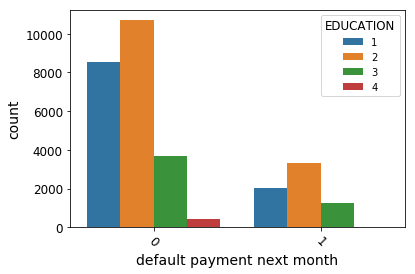

In [15]:
df1=df
labels=['Current','Default']
sns.countplot(x=('default payment next month'),data=df1,hue='EDUCATION')
plt.xticks(rotation=-45)

Default ratio is higher amongst university graduate vs others.

In [16]:
table_sex=pd.pivot_table(df,index=['default payment next month'],values='EDUCATION',columns='SEX',
                      aggfunc='count',fill_value=0,margins=True)
print(table_sex)
print('1=Male,2=Female')

SEX                             1      2    All
default payment next month                     
0                            9015  14349  23364
1                            2873   3763   6636
All                         11888  18112  30000
1=Male,2=Female


(array([0, 1]), <a list of 2 Text xticklabel objects>)

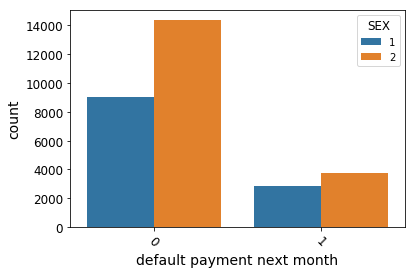

In [17]:
sns.countplot(x=('default payment next month'),data=df1,hue='SEX')
plt.xticks(rotation=-45)

Default ratio amongst female is higher than male.

In [18]:
table_marriage=pd.pivot_table(df,index=['default payment next month'],values='SEX',columns='MARRIAGE',
                      aggfunc='count',fill_value=0,margins=True)
print(table_marriage)
print('Marital status (1 = married; 2 = single; 3&0 = others)')

MARRIAGE                        1      2    3    All
default payment next month                          
0                           10453  12623  288  23364
1                            3206   3341   89   6636
All                         13659  15964  377  30000
Marital status (1 = married; 2 = single; 3&0 = others)


(array([0, 1]), <a list of 2 Text xticklabel objects>)

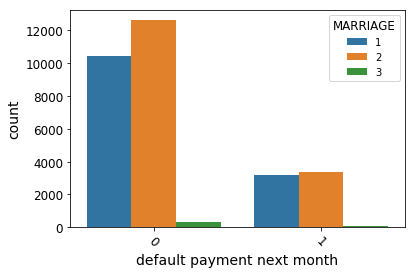

In [19]:
sns.countplot(x=('default payment next month'),data=df1,hue='MARRIAGE')
plt.xticks(rotation=-45)

Default ratio is almost equal in married vs single status.

In [20]:
table_age1=pd.pivot_table(df,index=['default payment next month'],values='SEX',columns='AGE',
                      aggfunc='count',fill_value=0,margins=True)
table_age1

AGE,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,79,All
default payment next month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,53,391,684,827,884,1003,1164,1123,1292,1121,988,933,931,931,887,854,812,750,755,683,639,609,520,538,501,413,381,362,333,310,252,226,251,191,152,129,95,91,62,44,35,37,23,22,19,18,11,4,12,8,3,2,1,1,2,1,23364
1,14,169,247,300,302,253,313,286,313,274,229,225,215,231,226,254,229,194,199,187,185,185,150,162,116,157,120,104,119,101,88,78,74,56,57,49,27,31,21,23,21,7,8,9,5,7,5,1,3,2,0,1,3,0,1,0,6636
All,67,560,931,1127,1186,1256,1477,1409,1605,1395,1217,1158,1146,1162,1113,1108,1041,944,954,870,824,794,670,700,617,570,501,466,452,411,340,304,325,247,209,178,122,122,83,67,56,44,31,31,24,25,16,5,15,10,3,3,4,1,3,1,30000


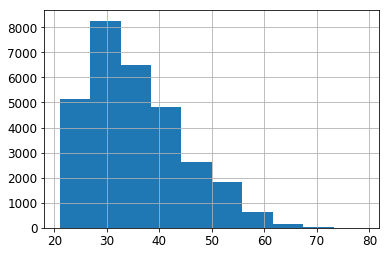

In [21]:
df.AGE.hist()

Majority of age groups between 20 to 45 years. Ratio of retires are very minimal

# DATA Analysis - Combination of variables vs default to identify outliers

**1. Review relationship between Education & Marriage Vs Default**

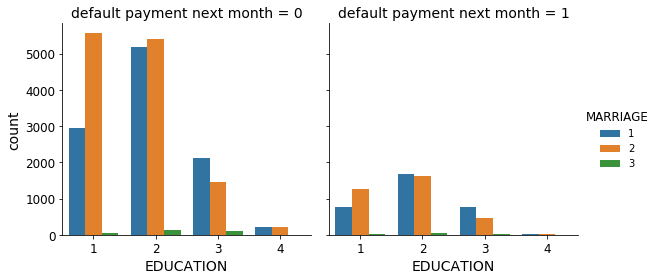

In [22]:
g = sns.catplot(x="EDUCATION", hue="MARRIAGE", col='default payment next month',
...                 data=df1, kind="count",
...                 height=4, aspect=1);

Overall university degree candidates are in high default category.

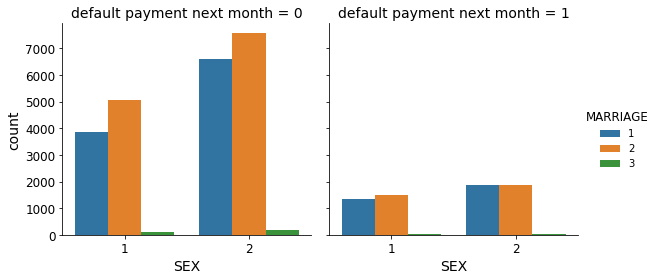

In [23]:
g = sns.catplot(x="SEX", hue="MARRIAGE", col='default payment next month',
...                 data=df1, kind="count",
...                 height=4, aspect=1);

No outliers between sex & marriage. This is just for FYI

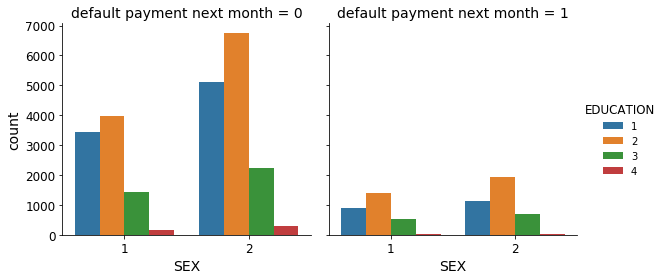

In [24]:
g = sns.catplot(x="SEX", hue="EDUCATION", col='default payment next month',
...                 data=df1, kind="count",
...                 height=4, aspect=1);

Overall Female with university degree has overall high default ration

In [0]:
from pandas.plotting import scatter_matrix
df1=df[['default payment next month','SEX','EDUCATION','MARRIAGE','AGE']]
scatter_matrix(df1, alpha=0.2, figsize=(12, 12))

2. Analysis of payment period of customers

In [0]:
from pandas.plotting import scatter_matrix
df1=df[['default payment next month','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
scatter_matrix(df1, alpha=0.2, figsize=(12, 12))

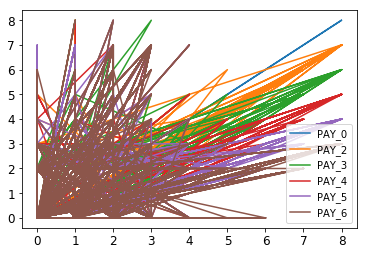

In [25]:
plt.subplots()

plt.plot(df['PAY_0'],df['PAY_0'])
plt.plot(df['PAY_0'],df['PAY_2'])
plt.plot(df['PAY_0'],df['PAY_3'])
plt.plot(df['PAY_0'],df['PAY_4'])
plt.plot(df['PAY_0'],df['PAY_5'])
plt.plot(df['PAY_0'],df['PAY_6'])

plt.legend(loc='lower right')

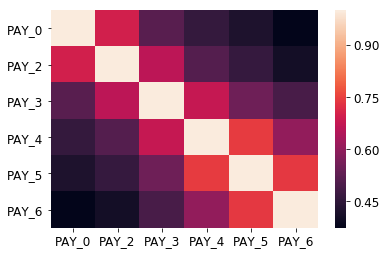

In [26]:
# Calculate correlations
corr = df1[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].corr()
 
# Heatmap
sns.heatmap(corr)

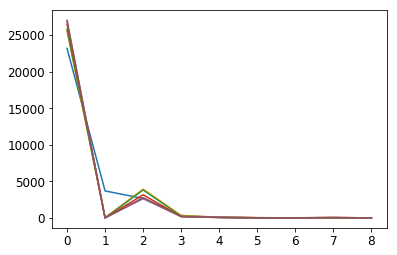

In [27]:
plt.subplots()
x=(0,1,2,3,4,5,6,7,8)
y_month1=(23182,3688,2667,322,76,26,11,9,19) #driven from value counts command i.e. df['PAY_0'].value_counts()
y_month2=(25562,28,3927,326,99,25,12,20,1)# manual input
y_month3=(25787,4,3819,240,76,21,23,27,3)
y_month4=(26490,2,3159,180,69,35,5,58,2)
y_month5=(27032,0,2626,178,84,17,4,58,1)
y_month6=(26921,0,2766,184,49,13,19,46,2)

plt.plot(x,y_month1)
plt.plot(x,y_month2)
plt.plot(x,y_month3)
plt.plot(x,y_month4)
plt.plot(x,y_month5)
plt.plot(x,y_month6)

The monthly count of payment timeline shows that majority of the default category is in month 2 which is close to 5K records. Remaining counts of default are not in high numbers

**3. Analysis of credit balance versus limit**

In [0]:
from pandas.plotting import scatter_matrix
df1=df[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
scatter_matrix(df1, alpha=0.2, figsize=(12, 12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca4b097978>,
      dtype=object)

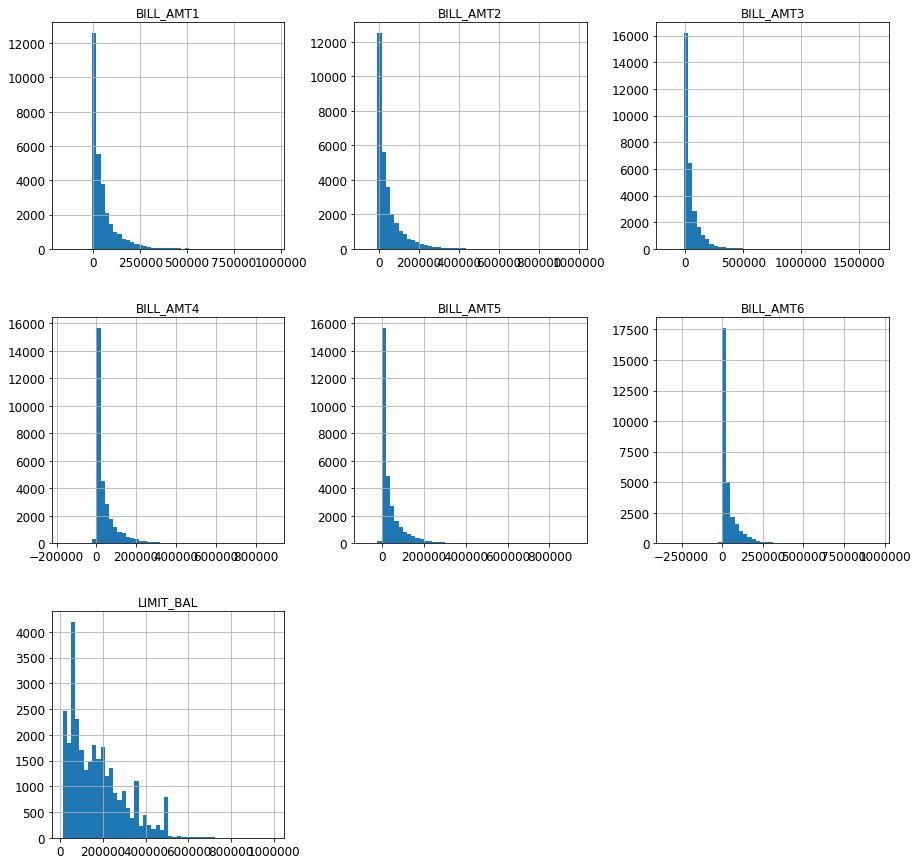

In [28]:
df[['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].hist(bins=50,
                                                                                                figsize=(15,15))

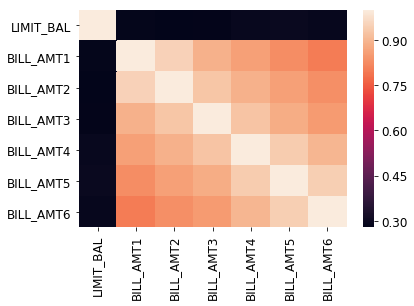

In [29]:
# Calculate correlations
corr = df1[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].corr()
 
# Heatmap
sns.heatmap(corr)

The above chart shows there is high corelation in monthly balance over the period which means customers are accumulating debt over the period. Below chart also support this fact as monthly payments are flat.

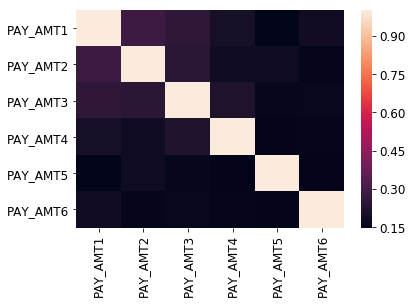

In [30]:
# Calculate correlations
corr = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].corr()
 
# Heatmap
sns.heatmap(corr)

This chart is showing that there is no corelation in monthly payments over the period which in contrast to the debt balance chart which shows that customers monthly balances have high corelation. In summary customers are paying minimum payment to avoid default.


# Data Preprocessing and Pipeline



In [0]:
numeric_features = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [0]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])



In [0]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [0]:

Kneighbors_clf= Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(),)])
Randomforest_clf= Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(),)])


# Data Split - Target & Train_Test_Split

In [36]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']
print(X.shape)
print(y.shape)

(30000, 24)
(30000,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(24000, 24) (24000,)
(6000, 24) (6000,)


In [0]:
X_scaled=preprocessor.fit_transform(X_train)
X_test_scaled=preprocessor.transform(X_test)

# GridSearchCV -Best Parameters
KNeighbors and Random Classifiers

In [41]:
# KNEIGHBORS CLASSIFIER

para_grid={'n_neighbors':[3, 4, 5, 7, 10, 20, 50]}

gs=GridSearchCV(KNeighborsClassifier(),para_grid,cv=4,verbose=1,n_jobs=-1)
gs_results=gs.fit(X_scaled,y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  4.0min finished


In [42]:
[gs_results.best_score_,gs_results.best_params_,gs_results.best_estimator_]


[0.808875,
 {'n_neighbors': 20},
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                      weights='uniform')]

In [43]:
random_clf=RandomForestClassifier()
param_grid={'n_estimators':[3, 4, 6, 7, 10, 20, 50, 100]}
grid_search=GridSearchCV(random_clf,param_grid,cv=4,verbose=1,n_jobs=-1)
grid_randaom=grid_search.fit(X_scaled,y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  2.1min finished


In [44]:
[grid_randaom.best_score_,grid_randaom.best_params_,grid_randaom.best_estimator_]

[0.8162916666666666,
 {'n_estimators': 50},
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=50,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)]

In [0]:
i=gs_results.best_params_
j=grid_randaom.best_params_


# DEF for Graphs

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="upper right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1])             

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.legend()
    plt.grid(True)

# KNEIGHBORS - WITHOUT AND WITH DATA SCALING

1. WITHOUT DATA SCALING
PERFORMANCE METRICS: KNN Score, Cross Validation Score, Confusion Matrix, Precision/Recall/F1 Scores, Precision_Recall_Curve,ROC_AUC Score & ROC_Curve

KNN Score: 0.78575
CROSS_VAL Score: [0.77616667 0.77383333 0.77783333 0.77383333]
Confusion Matrix: [[18294   374]
 [ 5016   316]]
Precision Score: 0.4579710144927536
Recall Score: 0.05926481620405101
F1 Score: 0.10494852208568581


No handles with labels found to put in legend.


ROC_AUC Score: 0.6355235674544305


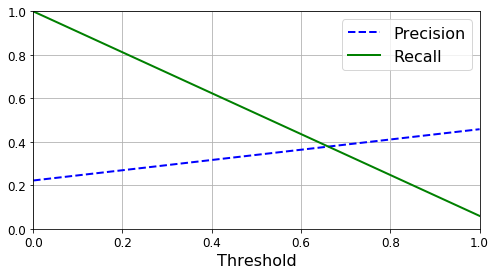

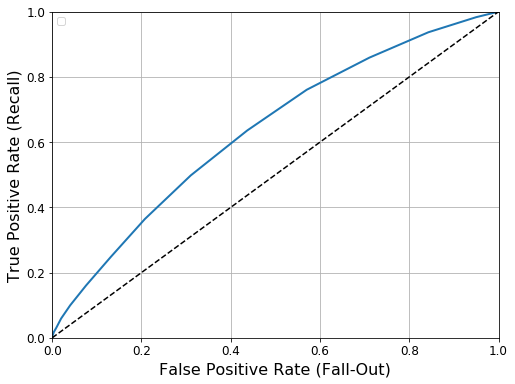

In [47]:
# KNN best fit evaluation without DATA SCALING

knn_clf=KNeighborsClassifier(n_neighbors=i['n_neighbors'])
knn_clf.fit(X_train,y_train)
cv=4

print('KNN Score: {}'.format(knn_clf.score(X_train,y_train)))

print('CROSS_VAL Score: {}'.format(cross_val_score(knn_clf, X_train, y_train, cv=cv, scoring="accuracy")))

y_train_predict=cross_val_predict(knn_clf,X_train,y_train,cv=cv)
print('Confusion Matrix: {}'.format(confusion_matrix(y_train,y_train_predict)))
print('Precision Score: {}'.format(precision_score(y_train,y_train_predict)))
print('Recall Score: {}'.format(recall_score(y_train,y_train_predict)))
print('F1 Score: {}'.format(f1_score(y_train,y_train_predict)))

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_predict)
plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

y_train_predict_proba=cross_val_predict(knn_clf, X_train, y_train, cv=cv, method="predict_proba")
y_scores_forest = y_train_predict_proba[:, 1] # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)
print('ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest)))

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr_forest, tpr_forest)               
plt.show()


In [48]:
print('Summary: Without Feature Scaling ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest)))

Summary: Without Feature Scaling ROC_AUC Score: 0.6355235674544305


2. WITH DATA SCALING PERFORMANCE METRICS: KNN Score, Cross Validation Score, Confusion Matrix, Precision/Recall/F1 Scores, Precision_Recall_Curve,ROC_AUC Score & ROC_Curve

KNN Score: 0.8179166666666666
CROSS_VAL Score: [0.807      0.80966667 0.812      0.80683333]
Confusion Matrix: [[17997   671]
 [ 3916  1416]]
Precision Score: 0.678485864877815
Recall Score: 0.26556639159789946
F1 Score: 0.38172260412454506


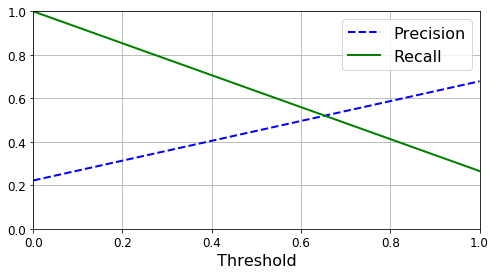

No handles with labels found to put in legend.


ROC_AUC Score: 0.7353515011225487


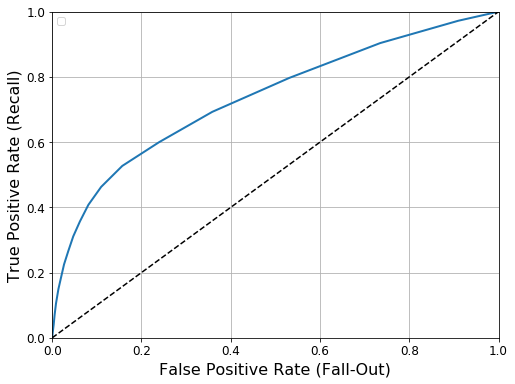

In [49]:
# KNN best fit evaluation with DATA SCALING

knn_clf=KNeighborsClassifier(n_neighbors=i['n_neighbors'])
knn_clf.fit(X_scaled,y_train)
print('KNN Score: {}'.format(knn_clf.score(X_scaled,y_train)))

print('CROSS_VAL Score: {}'.format(cross_val_score(knn_clf, X_scaled, y_train, cv=cv, scoring="accuracy")))

y_train_predict=cross_val_predict(knn_clf,X_scaled,y_train,cv=cv)
print('Confusion Matrix: {}'.format(confusion_matrix(y_train,y_train_predict)))
print('Precision Score: {}'.format(precision_score(y_train,y_train_predict)))
print('Recall Score: {}'.format(recall_score(y_train,y_train_predict)))
print('F1 Score: {}'.format(f1_score(y_train,y_train_predict)))

precisions1, recalls1, thresholds1 = precision_recall_curve(y_train, y_train_predict)
plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions1, recalls1, thresholds1)               
plt.show()

y_train_predict_proba=cross_val_predict(knn_clf, X_scaled, y_train, cv=cv, method="predict_proba")
y_scores_forest1 = y_train_predict_proba[:, 1] # score = proba of positive class 
fpr_forest1, tpr_forest1, thresholds_forest1 = roc_curve(y_train,y_scores_forest1)
print('ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest1)))

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr_forest1, tpr_forest1)               
plt.show()

In [50]:
print('Summary: KNN With Feature Scaling ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest1)))
print('Summary: KNN Without Feature Scaling ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest)))


Summary: KNN With Feature Scaling ROC_AUC Score: 0.7353515011225487
Summary: KNN Without Feature Scaling ROC_AUC Score: 0.6355235674544305


AUC score improve by 0.1 once applied scalling on the data.

# RANDOM FOREST - WITHOUT AND WITH DATA SCALING

Random CLF Score: 0.999125
[0.811      0.811      0.82716667 0.815     ]
Confusion Matrix: [[17636  1032]
 [ 3392  1940]]
Precision Score: 0.6527590847913862
Recall Score: 0.36384096024006
F1 Score: 0.46724470134874757


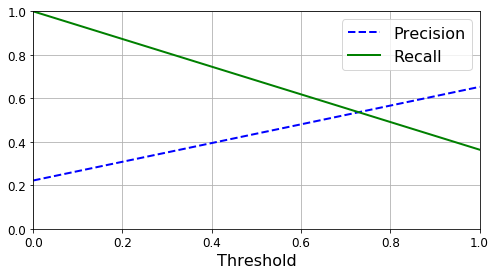

No handles with labels found to put in legend.


ROC_AUC Score: 0.7600251134805343


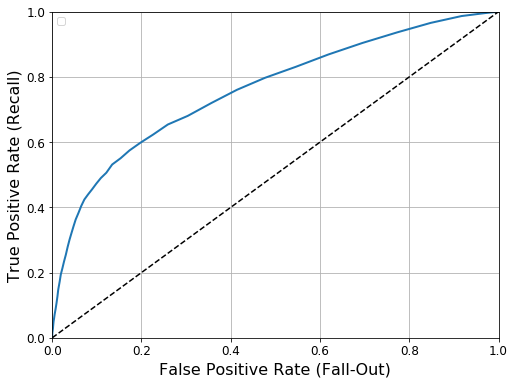

In [51]:
# Random Forest with No Data Scaling

random_clf = RandomForestClassifier(n_estimators=j['n_estimators'])
random_clf.fit(X_train,y_train)
print('Random CLF Score: {}'.format(random_clf.score(X_train,y_train)))

print(cross_val_score(random_clf, X_train, y_train, cv=cv, scoring="accuracy"))

y_train_predict2=cross_val_predict(random_clf,X_train,y_train,cv=cv)
print('Confusion Matrix: {}'.format(confusion_matrix(y_train,y_train_predict2)))
print('Precision Score: {}'.format(precision_score(y_train,y_train_predict2)))
print('Recall Score: {}'.format(recall_score(y_train,y_train_predict2)))
print('F1 Score: {}'.format(f1_score(y_train,y_train_predict2)))

precisionsR, recallsR, thresholdsR = precision_recall_curve(y_train, y_train_predict2)
plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisionsR, recallsR, thresholdsR)               
plt.show()

y_train_predict_proba2=cross_val_predict(random_clf, X_train, y_train, cv=cv, method="predict_proba")
y_scores_forest2 = y_train_predict_proba2[:, 1] # score = proba of positive class 
fpr_forestR, tpr_forestR, thresholds_forestR = roc_curve(y_train,y_scores_forest2)
print('ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest2)))

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr_forestR, tpr_forestR)            
plt.show()

RANDOM FOREST WITH DATA SCALING

Random CLF Score: 0.99875
[0.80933333 0.814      0.8245     0.81566667]
Confusion Matrix: [[17632  1036]
 [ 3405  1927]]
Precision Score: 0.6503543705703678
Recall Score: 0.3614028507126782
F1 Score: 0.46461723930078364


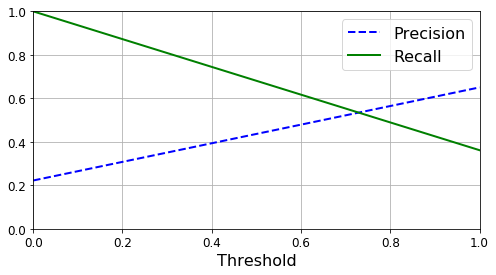

No handles with labels found to put in legend.


ROC_AUC Score: 0.7601789395013206


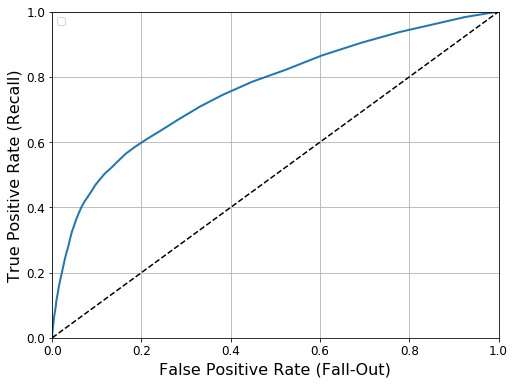

In [52]:
# Random Forest with  Data Scaling
random_clf = RandomForestClassifier(n_estimators=j['n_estimators'])
random_clf.fit(X_scaled,y_train)
print('Random CLF Score: {}'.format(random_clf.score(X_scaled,y_train)))

print(cross_val_score(random_clf, X_scaled, y_train, cv=cv, scoring="accuracy"))

y_train_predict2=cross_val_predict(random_clf,X_scaled,y_train,cv=cv)
print('Confusion Matrix: {}'.format(confusion_matrix(y_train,y_train_predict2)))
print('Precision Score: {}'.format(precision_score(y_train,y_train_predict2)))
print('Recall Score: {}'.format(recall_score(y_train,y_train_predict2)))
print('F1 Score: {}'.format(f1_score(y_train,y_train_predict2)))

precisionsR1, recallsR1, thresholdsR1 = precision_recall_curve(y_train, y_train_predict2)
plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisionsR1, recallsR1, thresholdsR1)               
plt.show()

y_train_predict_proba2=cross_val_predict(random_clf, X_scaled, y_train, cv=cv, method="predict_proba")
y_scores_forest3 = y_train_predict_proba2[:, 1] # score = proba of positive class 
fpr_forestR1, tpr_forestR1, thresholds_forestR1 = roc_curve(y_train,y_scores_forest3)
print('ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest3)))

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr_forestR1, tpr_forestR1)              
plt.show()

In [53]:
print('ROC_AUC Score Random Forest with Scaling: {}'.format(roc_auc_score(y_train, y_scores_forest3)))
print('ROC_AUC Score Random Forest without Scaling: {}'.format(roc_auc_score(y_train, y_scores_forest2)))

ROC_AUC Score Random Forest with Scaling: 0.7601789395013206
ROC_AUC Score Random Forest without Scaling: 0.7600251134805343


AUC area of without scaling is 0.0002 points higher than with data scalling. Almost no impact of scalling.

# KNN VS RANDOM FOREST -  ROC_CURVE AND AUC_RUC SCORE

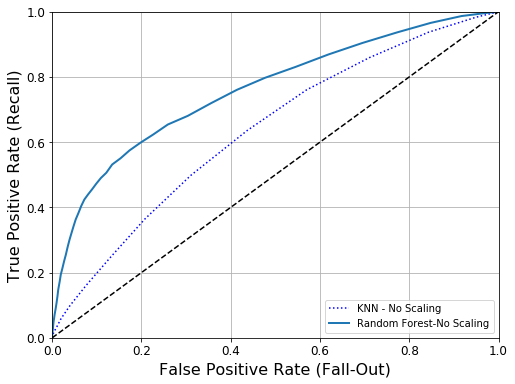

In [54]:
plt.figure(figsize=(8, 6))                         # Not shown
plt.plot(fpr_forest, tpr_forest,'b:',label='KNN - No Scaling')
plot_roc_curve(fpr_forestR, tpr_forestR,'Random Forest-No Scaling')
plt.legend(loc='lower right')
plt.show()

AUC area is much higer in Random Forest before applying any scaling.

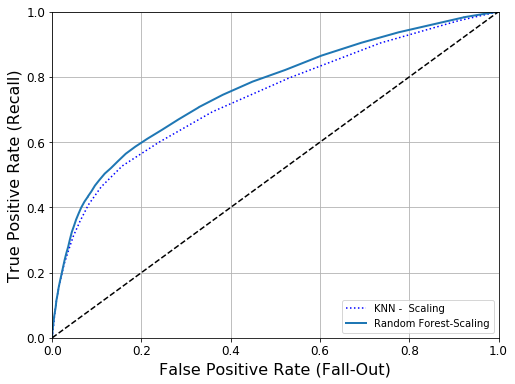

In [55]:
plt.figure(figsize=(8, 6)) 
plt.plot(fpr_forest1, tpr_forest1,'b:',label='KNN -  Scaling')
plot_roc_curve(fpr_forestR1, tpr_forestR1,'Random Forest-Scaling')
plt.legend(loc='lower right')
plt.show()

With Scaling KNN has imporved but Random Forest has not changed much.

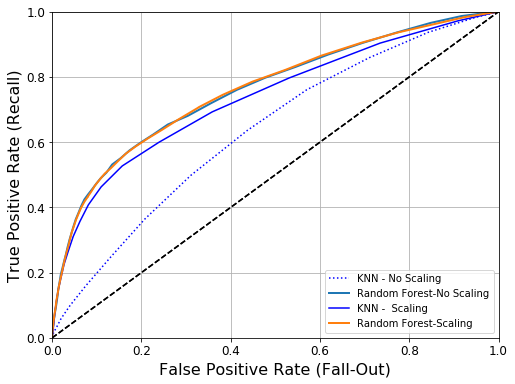

In [56]:
plt.figure(figsize=(8, 6))                         # Not shown
plt.plot(fpr_forest, tpr_forest,'b:',label='KNN - No Scaling')
plot_roc_curve(fpr_forestR, tpr_forestR,'Random Forest-No Scaling')
plt.plot(fpr_forest1, tpr_forest1,'b-',label='KNN -  Scaling')
plot_roc_curve(fpr_forestR1, tpr_forestR1,'Random Forest-Scaling')
plt.legend(loc='lower right')
plt.show()

In [57]:
print('Summary: KNN With Feature Scaling ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest1)))
print('Summary: KNN Without Feature Scaling ROC_AUC Score: {}'.format(roc_auc_score(y_train, y_scores_forest)))


print('Summary: Random Forest With Feature Scaling ROC_AUC Score:: {}'.format(roc_auc_score(y_train, y_scores_forest3)))
print('Summary: Random Forest Without Feature Scaling ROC_AUC Score:: {}'.format(roc_auc_score(y_train, y_scores_forest2)))

Summary: KNN With Feature Scaling ROC_AUC Score: 0.7353515011225487
Summary: KNN Without Feature Scaling ROC_AUC Score: 0.6355235674544305
Summary: Random Forest With Feature Scaling ROC_AUC Score:: 0.7601789395013206
Summary: Random Forest Without Feature Scaling ROC_AUC Score:: 0.7600251134805343


# Conclusion : 

Random Forest without scaling AUC_ROC_Score is highest and should be selected for test model

# TEST SET -Results

Random CLF Score: 0.9993333333333333
[0.81266667 0.81133333 0.806      0.82333333]
Confusion Matrix: [[4443  253]
 [ 853  451]]
Precision Score: 0.640625
Recall Score: 0.3458588957055215
F1 Score: 0.44920318725099595


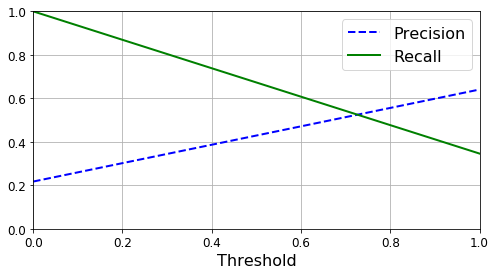

No handles with labels found to put in legend.


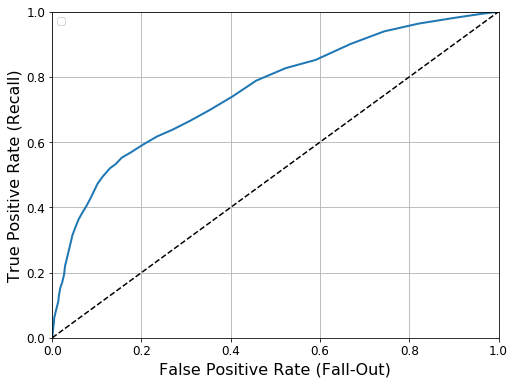

ROC_AUC Score: 0.7560006525590243


In [64]:
random_clf.predict(X_test_scaled)
print('Random CLF Score: {}'.format(random_clf.score(X_test_scaled,y_test)))
print(cross_val_score(random_clf, X_test_scaled,y_test, cv=cv, scoring="accuracy"))
y_test_predict=cross_val_predict(random_clf,X_test_scaled,y_test,cv=cv)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test,y_test_predict)))
print('Precision Score: {}'.format(precision_score(y_test,y_test_predict)))
print('Recall Score: {}'.format(recall_score(y_test,y_test_predict)))
print('F1 Score: {}'.format(f1_score(y_test,y_test_predict)))

precisionsR1T, recallsR1T, thresholdsR1T = precision_recall_curve(y_test,y_test_predict)
plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisionsR1T, recallsR1T, thresholdsR1T)                
plt.show()

y_test_predict_proba2T=cross_val_predict(random_clf, X_test_scaled,y_test, cv=cv, method="predict_proba")
y_scores_forest3T = y_test_predict_proba2T[:, 1] # score = proba of positive class 
fpr_forestR1T, tpr_forestR1T, thresholds_forestR1T = roc_curve(y_test,y_scores_forest3T)

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr_forestR1T, tpr_forestR1T)             
plt.show()

print('ROC_AUC Score: {}'.format(roc_auc_score(y_test, y_scores_forest3T)))



AUC Score - Training 0.7600 vs Test 0.756. Overall test result is performing as predicted by training. Looks like it is neither underfitting (test is not performing to well vs train) not overfitting(test is performing poorly vs train). Further evaluation required to see if this can be improved.

Random CLF Score: 0.9993333333333333
[0.8101582  0.79166667 0.80916667 0.7975     0.81984987]
Confusion Matrix: [[4415  281]
 [ 868  436]]
Precision Score: 0.6080892608089261
Recall Score: 0.3343558282208589
F1 Score: 0.43146956952003956


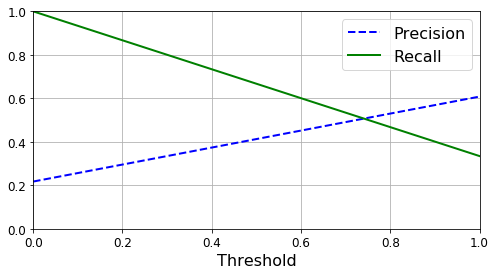

No handles with labels found to put in legend.


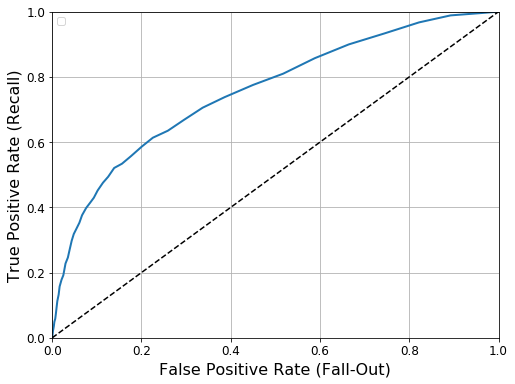

ROC_AUC Score: 0.7557659860630638


In [65]:
# CV=5
cv1=5

random_clf.predict(X_test_scaled)
print('Random CLF Score: {}'.format(random_clf.score(X_test_scaled,y_test)))

print(cross_val_score(random_clf, X_test_scaled,y_test, cv=cv1, scoring="accuracy"))

y_test_predict=cross_val_predict(random_clf,X_test_scaled,y_test,cv=cv1)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test,y_test_predict)))
print('Precision Score: {}'.format(precision_score(y_test,y_test_predict)))
print('Recall Score: {}'.format(recall_score(y_test,y_test_predict)))
print('F1 Score: {}'.format(f1_score(y_test,y_test_predict)))

precisionsR1T, recallsR1T, thresholdsR1T = precision_recall_curve(y_test,y_test_predict)
plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisionsR1T, recallsR1T, thresholdsR1T)               
plt.show()

y_test_predict_proba2T=cross_val_predict(random_clf, X_test_scaled,y_test, cv=cv1, method="predict_proba")
y_scores_forest3T = y_test_predict_proba2T[:, 1] # score = proba of positive class 
fpr_forestR1T, tpr_forestR1T, thresholds_forestR1T = roc_curve(y_test,y_scores_forest3T)

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr_forestR1T, tpr_forestR1T)              
plt.show()

print('ROC_AUC Score: {}'.format(roc_auc_score(y_test, y_scores_forest3T)))



With CV=5 the AUC score 0.7557 not imporved  from  0.7560.  However, this is close to training prediction 0.7658. Not much change.

# THINGS TO DO




1. Data website link is nor working/Learn how to group the AGE field/ Pipeline is not used related to algorithm
2. Evaluate alogrithm performance through learning curve graph (overfitting or underfitting)
4. Saving in Github and pdf
5. 


